# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from os.path import exists
from sklearn.cluster import KMeans

In [2]:
if not exists('mnist.csv'):
    X, y = fetch_openml(name="mnist_784", version=1,
                        return_X_y=True, as_frame=False)
    X, Y = pd.DataFrame(X), pd.DataFrame({'Label': y})
    X.join(Y).to_csv('mnist.csv', index=False)


df = pd.read_csv('mnist.csv')
X, Y = df.iloc[:, :784].values, df['Label'].values


b) Plot the singular value plot for a single example of the 0 digit (5 points)

Text(0, 0.5, 'Singular Values')

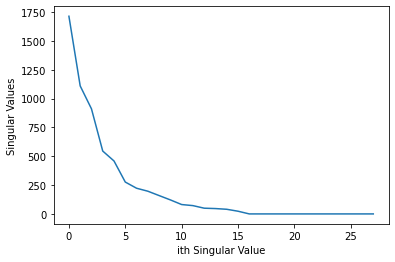

In [3]:
zero = df[df['Label'] == 0].sample()
zero = zero.iloc[:, :784].values.reshape(28, 28)

u, s, v = np.linalg.svd(zero)
u.shape, s.shape, v.shape
plt.plot(s)
plt.xlabel('ith Singular Value')
plt.ylabel('Singular Values')

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

Text(0.5, 0.98, 'Original vs Compressed')

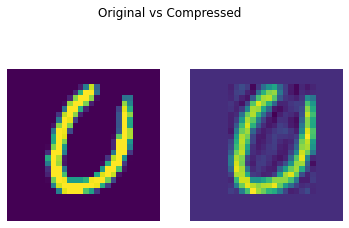

In [4]:
rank = 6
compressed_zero = u[:, :rank] @ np.diag(s[:rank]) @ v[:rank]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(zero)
axes[0].set_axis_off()
axes[1].imshow(compressed_zero)
axes[1].set_axis_off()
fig.suptitle('Original vs Compressed')

d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

In [5]:
def compressImage(image, rank=28):
    u, s, v = np.linalg.svd(image.reshape(28, 28))
    newImage = u[:, :(rank + 1)] @ np.diag(s[:(rank + 1)]) @ v[:(rank + 1)]
    return newImage.reshape(784)

def compressData(data, rank=28):
    compressedData = []
    for row in data:
        compressedData.append(compressImage(row, rank))
    return np.array(compressedData)

In [6]:
if not exists('compressed_mnist.csv'):
    X_comp = compressData(df.iloc[:, :784].values, 5)
    pd.DataFrame(X_comp).join(df['Label']).to_csv('compressed_mnist.csv', index=False)

df_compressed = pd.read_csv('compressed_mnist.csv')

-> answer

One would probably look at the singular values on a graph, for each digit, and pick the number of singular values to keep, in order to have a relatively good reconstruction of each digit. I chose to keep 5.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

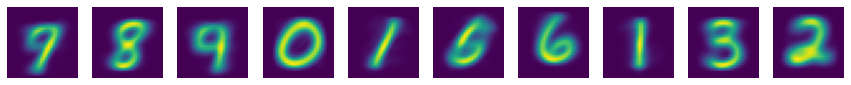

In [7]:
kmeans_compressed = KMeans(n_clusters=10).fit(df_compressed.iloc[:, :784].values)

fig, axes = plt.subplots(1, 10)
for ax, digit in zip(axes, kmeans_compressed.cluster_centers_):
  ax.set_axis_off()
  img = digit.reshape(28, 28)
  ax.imshow(img)

fig.set_figwidth(15)
fig.set_figheight(15)

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

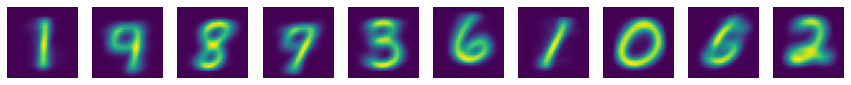

In [8]:
kmeans = KMeans(n_clusters=10).fit(df.iloc[:, :784].values)

fig, axes = plt.subplots(1, 10)
for ax, digit in zip(axes, kmeans.cluster_centers_):
  ax.set_axis_off()
  img = digit.reshape(28, 28)
  ax.imshow(img)

fig.set_figwidth(15)
fig.set_figheight(15)

->answer

The kmeans centres with the original dataset seems to be clustering centres more poorly than the kmeans with the compressed dataset

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [59]:
import sys
def disagreement_dist(P_labels, C_labels):
    """
    Calculate the disagreement distance between `P_Labels` and `C_Labels`
    """
    ans = 0
    m, n = len(P_labels), len(C_labels)
    for i in range(m):
        for j in range(i + 1, n):
            ans += (P_labels[i] == P_labels[j]) != (C_labels[i] == C_labels[j])
        sys.stdout.write("\r %d" % i)
    return ans

In [1]:
def disagreement_dist(P_labels, C_labels):
    ans = 0
    df_temp = pd.DataFrame({'Label': P_labels}).join(
        pd.DataFrame({'Predicted Label': C_labels}))
    df_temp = pd.DataFrame({'Predicted Label': C_labels}).join(P_labels)
    
    for i in range(10):
        temp = df_temp[df_temp['Label'] == i]
        s1 = temp['Predicted Label'].value_counts()
        nums = 0
        sum = s1.sum()
        for val in s1.values:
            nums += val
            ans += val * (sum - nums)

        temp = df_temp[df_temp['Predicted Label'] == i]
        s1 = temp['Label'].value_counts()
        nums = 0
        sum = s1.sum()
        for val in s1.values:
            nums += val
            ans += val * (sum - nums)
        
    return ans

# print(dis(labels, labels['Predicted Label']))
# labels = pd.DataFrame({
#     'Label': [1, 1, 2, 3, 3],
#     'Predicted Label': [1, 2, 1, 3, 4]
# })

# print(dis(labels, labels['Predicted Label']))

In [69]:
compressed_dist = disagreement_dist(df_compressed['Label'], kmeans_compressed.labels_)
original_dist = disagreement_dist(df['Label'], kmeans.labels_)

print('The disagreement distance of the compressed image clustering is: {}'.format(compressed_dist))
print('The disagreement distance of the original image clustering is: {}'.format(original_dist))

The disagreement distance of the compressed image clustering is: 288947451
The disagreement distance of the original image clustering is: 288675700


-> answer

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [ ]:
diff_mat = np.zeros((784, 784))

compressed_df = df.copy(deep=True)
compressed_df['Image'] = compressed_df['Image'].apply(lambda x: compressImage(x, 10))

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
# from collections import defaultdict
import pandas as pd
from nltk import word_tokenize

categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.guns']
news_data = fetch_20newsgroups(subset='train', categories=categories)


b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [3]:
news_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
stemmer = SnowballStemmer('english')
cleaned_articles = []
stems = []

for article in news_data['data']:
    for token in word_tokenize(article):
        stems.append(stemmer.stem(token))
        # print(word)
    # cleaned_articles.append(stems)
    # break


In [5]:
print(len(stems))

872359


c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [6]:
vectoriser = TfidfVectorizer(max_df=1.0, min_df=1)
X = vectoriser.fit_transform(stems)

In [7]:
# file = pd.DataFrame.sparse.from_spmatrix(X)
# file.to_csv('vectorised_data.csv')

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

In [8]:
print(X.shape)

(872359, 31506)


In [9]:
def reduceDims(dataset, k):
    u, s, v = np.linalg.svd(dataset)
    return u[:, :(k + 1)] @ np.diag(s[:(k + 1)]) @ v[:(k + 1)]

In [10]:
test = X.toarray()

disagreement_distance = []
for k in range(1,25):
    # dim_reduced_dataset = # your code here
    dim_reduced_dataset = reduceDims(test, k)
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))
    print(k)

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

-> answer